In [1]:
!pip install torch torchvision torchaudio pennylane cotengra quimb torchmetrics --upgrade

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
#import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

#jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
#import jax.numpy as jnp

#import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
#import torch_xla
#import torch_xla.core.xla_model as xm



import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

#from jax.lib import xla_bridge


sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.set_default_dtype(torch.double)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#COMPLEX_DTYPE = torch.cfloat #torch.cdouble
#REAL_DTYPE = torch.float

print(device)

cuda


In [3]:
preprocess = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Lambda(lambda x: torch.squeeze(x)),
    #torchvision.transforms.Lambda(lambda x: x / torch.trace(x)),
    #torchvision.transforms.Lambda(lambda x: (x+torch.t(x))/2)
    torchvision.transforms.Normalize((0.5,), (0.5,)),
    #torchvision.transforms.Lambda(lambda x: x.type(COMPLEX_DTYPE))
])

train_dataset = torchvision.datasets.CIFAR10(
    "CIFAR10",
    train=True,
    download=True,
    transform=preprocess,
)
test_dataset = torchvision.datasets.CIFAR10(
    "CIFAR10",
    train=False,
    download=True,
    transform=preprocess,
)
dummy_trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)
dummy_testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True
)

dummy_x, dummy_y = next(iter(dummy_trainloader))

print(dummy_x.shape)  # 64x32x32
print(dummy_y.shape)  # 64
print(dummy_y)
print(dummy_x[0,0,16])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64])
tensor([7, 2, 7, 6, 4, 5, 7, 1, 8, 1, 1, 0, 8, 9, 7, 3, 1, 4, 6, 8, 2, 6, 5, 1,
        5, 9, 7, 2, 6, 5, 5, 9, 3, 6, 1, 9, 7, 6, 2, 8, 1, 8, 4, 8, 9, 0, 1, 5,
        2, 3, 3, 2, 6, 2, 5, 7, 6, 1, 8, 7, 7, 1, 5, 6])
tensor([ 0.0275, -0.0196, -0.0353, -0.6078, -0.7961, -0.8118, -0.8196, -0.7569,
        -0.7490, -0.7176, -0.7490, -0.7569, -0.7647, -0.8118, -0.7569, -0.7412,
        -0.7804, -0.6157,  0.0118,  0.1294,  0.0902,  0.0902,  0.0196,  0.0196,
         0.0745,  0.0745,  0.0667,  0.0824,  0.0431,  0.0039, -0.0118,  0.0118])


In [4]:
class SimpleNet2(torch.nn.Module):
  def __init__(self):
    super(SimpleNet2, self).__init__()

    self.layers = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=3), # 32x30x30
        torch.nn.Conv2d(32, 64, kernel_size=3), # 64x28x28
        #torch.nn.Conv2d(64, 64, kernel_size=3), # 64x26x26
        #torch.nn.Conv2d(64, 64, kernel_size=3), # 64x24x24
        torch.nn.Flatten(),
        torch.nn.Linear(64*28*28, 10),
    )

  def forward(self, x):
    return self.layers(x)

net = SimpleNet2().to(device)
test_img = dummy_x.to(device)
print(test_img.shape)
print(net)
test_out = net(test_img)
print(test_out.shape)

torch.Size([64, 3, 32, 32])
SimpleNet2(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=50176, out_features=10, bias=True)
  )
)
torch.Size([64, 10])


In [5]:
import torchmetrics

BATCH_SIZE = 100
LEARNING_RATE = 3e-4
STEPS = 100
PRINT_EVERY_PERCENT = 0.2

def train(
    model,
    optim=torch.optim.SGD,
    criterion=torch.nn.CrossEntropyLoss,
    accuracy = torchmetrics.Accuracy,
    steps = 100,
    print_every_percent=0.1,
    batchsize = 100,
    lr = 0.001,
    device=torch.device("cpu")
):
  trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True
  )
  testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=True
  )

  n_train_batches = len(trainloader)
  n_test_batches = len(testloader)
  print_every_train_batch = int(n_train_batches*print_every_percent)
  print_every_test_batch = int(n_test_batches*print_every_percent)

  print(f"Number of train batches = {n_train_batches}, Number of test batches = {n_test_batches}")
  print(f"Print every train batch = {print_every_train_batch}, Print every test batch = {print_every_test_batch}")

  model.to(device)
  optimizer = optim(model.parameters(), lr=lr, momentum=0.9)
  loss = criterion()
  acc_func = accuracy(task="multiclass", num_classes=10).to(device)
  step_train_losses = []
  step_test_losses = []
  step_train_accs = []
  step_test_accs = []
  for i in range(steps):
    step_start = time.time()
    batch_train_loss = []
    batch_train_acc = []
    batch_test_loss = []
    batch_test_acc = []
    # train
    model.train()
    for batchid, (images, labels) in enumerate(trainloader):
      batch_start = time.time()
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      train_loss = loss(outputs, labels)
      train_loss.backward()
      optimizer.step()
      train_acc = acc_func(outputs, labels)
      batch_train_loss.append(train_loss.item())
      batch_train_acc.append(train_acc.item())
      batch_finish = time.time()

      if (batchid) % print_every_train_batch == 0:
        print(f"Training at step={i}, batch={batchid}, train loss = {train_loss.item()}, train acc = {train_acc.item()}, time = {batch_finish-batch_start}")

    # eval
    model.eval()
    with torch.no_grad():
      for batchid, (images, labels) in enumerate(testloader):
        batch_start = time.time()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss = loss(outputs, labels)
        test_acc = acc_func(outputs, labels)
        batch_test_loss.append(test_loss.item())
        batch_test_acc.append(test_acc.item())
        batch_finish = time.time()
        if (batchid) % print_every_test_batch == 0:
          print(f"Testing at step={i}, batch={batchid}, test loss = {test_loss.item()}, test acc = {test_acc.item()}, time = {batch_finish-batch_start}")

    step_train_losses.append(np.mean(batch_train_loss))
    step_test_losses.append(np.mean(batch_test_loss))
    step_train_accs.append(np.mean(batch_train_acc))
    step_test_accs.append(np.mean(batch_test_acc))
    step_finish = time.time()
    print(f"Step {i} finished in {step_finish-step_start}, Train loss = {step_train_losses[-1]}, Test loss = {step_test_losses[-1]}; Train Acc = {step_train_accs[-1]}, Test Acc = {step_test_accs[-1]}")

  return step_train_losses, step_test_losses, step_train_accs, step_test_accs

train_losses, test_losses, train_accs, test_accs = train(net,
                                                        optim=torch.optim.SGD,
                                                        criterion=torch.nn.CrossEntropyLoss,
                                                        accuracy = torchmetrics.Accuracy,
                                                        steps = STEPS,
                                                        print_every_percent=PRINT_EVERY_PERCENT,
                                                        batchsize = BATCH_SIZE,
                                                        lr = LEARNING_RATE,
                                                        device=device)

Number of train batches = 500, Number of test batches = 100
Print every train batch = 100, Print every test batch = 20
Training at step=0, batch=0, train loss = 2.2942078670143102, train acc = 0.09000000357627869, time = 0.1824660301208496
Training at step=0, batch=100, train loss = 1.9711621278371314, train acc = 0.3400000035762787, time = 0.00799250602722168
Training at step=0, batch=200, train loss = 2.019060596063117, train acc = 0.2800000011920929, time = 0.00811147689819336
Training at step=0, batch=300, train loss = 1.8727192687278469, train acc = 0.3799999952316284, time = 0.007997751235961914
Training at step=0, batch=400, train loss = 1.8566578837851488, train acc = 0.38999998569488525, time = 0.007956266403198242
Testing at step=0, batch=0, test loss = 1.7454867522008264, test acc = 0.38999998569488525, time = 0.0018415451049804688
Testing at step=0, batch=20, test loss = 1.9380294612108724, test acc = 0.3199999928474426, time = 0.0018892288208007812
Testing at step=0, batch

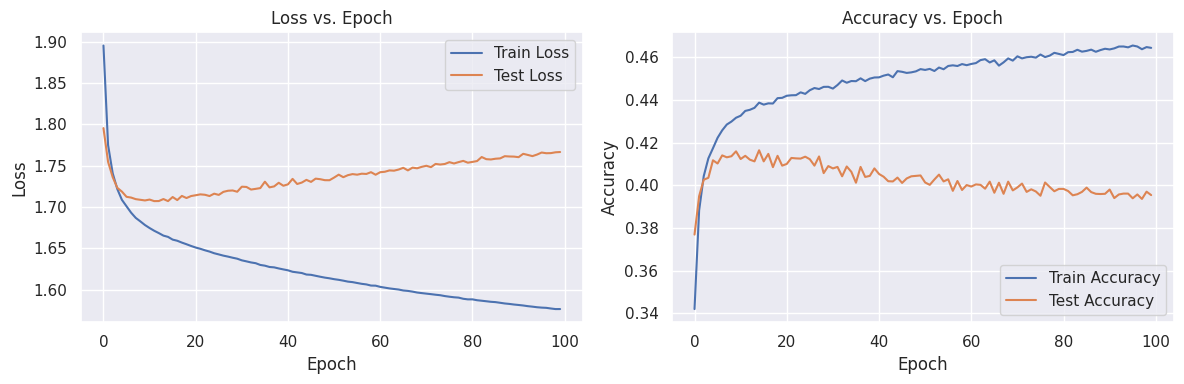

In [6]:
# plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the losses
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs. Epoch')
ax1.legend()

# Plot the accuracies
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs. Epoch')
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig("cifar10_simplenet2.pdf")
# Display the plots
plt.show()

In [7]:
import json

res_dict = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accs": train_accs,
    "test_accs": test_accs
}

with open("cifar10_simplenet2.json", "w") as f:
    json.dump(res_dict, f)